# Assignment 02: Logistic Regression from Scratch using a Neural Network Design (Example Solution)
---

**Due Date:** Tuesday 06/08/2025 (by midnight)

**Please fill these in before submitting, just in case I accidentally mix up file names while grading**:

Name: Jane Hacker

CWID-5: (Last 5 digits of cwid)

# Introduction 

Welcome to our second class assignment.  In this assignment you will be building the components
of a neural network like architecture by hand and from scratch, using basic numpy vectorized
operations.   You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**

- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**

- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all  functions above to train a set of trainable parameters.
- Use the trained model to make predictions and evaluate its performance.

# Packages

The following imports should be all of the backages that you will need for this assignment
(notice we are not yet using Keras/Tensorflow).  Run the cells below to import all of the
packages to be used in this assignment.  These same imports are given in the `src/assg_tasks.py` file
where you will implement your functions.

- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [1]:
# assignment wide imports go here, usually all of your imports for noteboosk should
# be put up at the top here, if they were not given to you at the start of the assignment
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [2]:
# The following ipython magic will reload changed file/modules.
# So when editing function in source code modules, you should
# be able to just rerun the cell, not restart the whole kernel.
%load_ext autoreload
%autoreload 2

In [3]:
# Import functions/moduls from this project.  We manually set the
# PYTHONPATH to append the location to search for this assignments
# functions to just ensure the imports are found
import sys
sys.path.append("../src")

# assignment function imports for doctests and github autograding
# these are required for assignment autograding
from assg_utils import run_unittests, run_doctests
from assg_tasks import load_dataset
from assg_tasks import flatten_image_dataset
from assg_tasks import standardize_image_dataset
from assg_tasks import sigmoid
from assg_tasks import initialize_parameters
from assg_tasks import forward_pass
from assg_tasks import backward_pass
from assg_tasks import optimize
from assg_tasks import predict

# Overview of the Problem Set

**Problem Statement**: You are given a dataset ("test_cat_noncat.h5 and train_catnoncat.h5", the
`load_dataset()` function is found in `src/assg_utils.py`) containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [4]:
# Loading the data (cat/non-cat)
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

We added "`_orig`" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with `train_x` and `test_x` (the labels `train_y` and `test_y` don't need any preprocessing).

Each row of your `train_x_orig` and `test_x_orig` is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `img_idx` value and re-run to see other images. 

y = 1
its a 'cat'


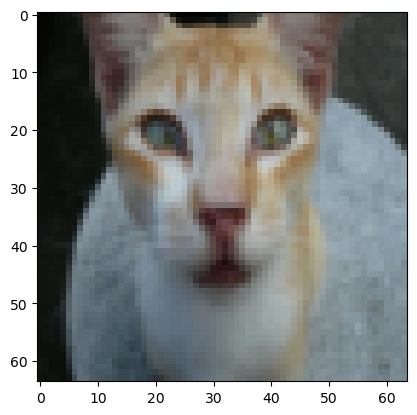

In [5]:
# Example of a picture
img_idx = 11
plt.imshow(train_x_orig[img_idx])

# get the target label, and its class name
class_idx = train_y[img_idx]
print("y = %d" % class_idx)
class_name = classes[class_idx].decode("utf-8")
print("its a '%s'" % class_name)

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Task:** In the next cell, first, display the shapes of the taining and test sets, both the input arrays
and the output labels.

Then find and set the values for:

- `m_train` (number of training examples)
- `m_test` (number of test examples)
- `num_px` (= height = width of a training image)

Remember that `train_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_x_orig.shape[0]`.

You will reuse `m_train`, `m_test`, `num_px` in the notebook after this, so make
sure you set these variable names exactly as shown.  Also notice that our images
are square images, so the width and height of the images are equal, thus we
only set `num_px` in this notebook.

In [6]:
### Display the shapes of the train and test arrays here, both
### the input data and the output label shapes
print("train_x shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

### set m_train, m_test and num_px to the correct values here
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]
print("m_train: %d" % m_train)
print("m_test: %d" % m_test)
print("num_px: %d" % num_px)

train_x shape: (209, 64, 64, 3)
train_y shape: (209,)
test_x shape: (50, 64, 64, 3)
test_y shape: (50,)
m_train: 209
m_test: 50
num_px: 64


**Expected values for `m_train`, `m_test` and `num_px`**

| variable    | value |
|-------------|-------|
| m_train     | 209   |
| m_test      | 50    |
| num_px      | 64    |

# Task 1: Clean and Standardize the train and test images

## Task 1.1: Flatten image pixels for training

**Task** Write a function to reshape the training and test data sets so
that images of size `(width, height, 3)` are flattened into single vectors of
shape `(width * height * 3)` for each image/row in the dataset.  Name the function
`flatten_image_dataset()`.  This function expects a 4-D tensor, where the
first index is the sample number, and the next 3 dimensions specify the
`(width, height, channels)` of the images in the dataset.  It returns
the flattened dataset images as a 2-D tensor of shape 
`(num_images, (width * height * channels))`.  Do not hardcode the number of
images nor the number of pixels.  **Hint**: you will again need to extract
the number of samples and number of pixels, but don't assume that images
are square here with equal numbers of pixels in the width and height.

In [7]:
### TESTED FUNCTION test_flatten_image_dataset()
run_unittests(['test_flatten_image_dataset'])

random_image_dataset = np.random.random((100, 128, 64, 3))
random_image_dataset_flattened = flatten_image_dataset(random_image_dataset)

print("original image dataset shape:")
print(random_image_dataset.shape)

### expected shape is (100, 24576)
print("flattened image dataset shape:")
print(random_image_dataset_flattened.shape)

test_random_matrix (test_assg_tasks.test_flatten_image_dataset.test_random_matrix)
test_random_matrix ... FAIL
test_test_set_images (test_assg_tasks.test_flatten_image_dataset.test_test_set_images)
test_test_set_images ... FAIL
test_train_set_images (test_assg_tasks.test_flatten_image_dataset.test_train_set_images)
test_train_set_images ... FAIL

FAIL: test_random_matrix (test_assg_tasks.test_flatten_image_dataset.test_random_matrix)
test_random_matrix
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in runWithWarningsS

original image dataset shape:
(100, 128, 64, 3)
flattened image dataset shape:
(2, 2)


**Task** Use your function to flatten the training and test image
datasets.  Assign the flattened datasets names of
`train__x_flat` and `test_x_flat` respectively.
If your function is working, you should find that your flattened
datasets have the following shapes.

| datase       | shape        |
|--------------|--------------|
| train_x_flat | (209, 12288) |
| test_x_flat  | (50, 12288)  |

In [8]:
### Flatten the image datasets using your function.  Create the asked for
### named variables.  Verify that the shapes of the flattened datasets are
### what you expect here.


As a final sanity check, lets redisplay an image again from the training dataset,
but extract it from the flattened set of images.

**TASK** Copy the code from above to display an image.  However, as more practice
with reshaping, you will need to "unflatten" the image by reshaping it into a
`(num_px, num_px, 3)` shaped array before passing it into the `plt.imshow()` function.

In [9]:
### Copy the code to extract an image and display it, from the 
### tensor of flattened pictures.  But before calling
### imshow, you will need to "unflatten" the image again
# Example of a picture


## Task 1.2: Standardize image dataset

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array (this is called mean normalization). But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).  The result will be that each pixel value will now be a floating point number in the range [0.0 - 1.0].

**Task**: Create a final function named `standardize_image_dataset()` that will take an image dataset, and it will first flatten the images, by reusing your previous `flatten_image_dataset()`.
Then it should standardize the pixels to be in the range [0.0 - 1.0] by dividing them
all by 255.

In [10]:
### TESTED FUNCTION test_standardize_image_dataset()
run_unittests(['test_standardize_image_dataset'])

random_image_dataset = np.random.randint(low=0, high=256, size=(100, 128, 64, 3))
random_image_dataset_flattened = standardize_image_dataset(random_image_dataset)

print("original image dataset shape:")
print(random_image_dataset.shape)

### expected shape is (100, 24576)
print("flattened image dataset shape:")
print(random_image_dataset_flattened.shape)

### expected that min and max are 0.0 and 1.0 respectively
print("minimum value after normalized: %f" % random_image_dataset_flattened.min())
print("maximum value after normalized: %f" % random_image_dataset_flattened.max())

test_random_matrix (test_assg_tasks.test_standardize_image_dataset.test_random_matrix)
test_random_matrix ... FAIL
test_test_set_images (test_assg_tasks.test_standardize_image_dataset.test_test_set_images)
test_test_set_images ... FAIL
test_train_set_images (test_assg_tasks.test_standardize_image_dataset.test_train_set_images)
test_train_set_images ... FAIL

FAIL: test_random_matrix (test_assg_tasks.test_standardize_image_dataset.test_random_matrix)
test_random_matrix
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in 

original image dataset shape:
(100, 128, 64, 3)
flattened image dataset shape:
(2, 2)
minimum value after normalized: 0.000000
maximum value after normalized: 0.000000


**Task**: Finally in the next cell reuse your `standardize_image_dataset()`
to standardize the original training and test input datasets.  Create
new variables named `train_x` and `test_x` by calling your function
to standardize the original datasets.  Demonstrate that the shapes are again
as expected and also that the pixel values have been standardized.

In [11]:
### standardize your train and test sets, make sure you end up with
### train_x and test_x variable names for your tensors to use in the rest
### of this notebook.  You should also demonstrate that the shape
### of the variables are correct, and that the min/max pixel value are 0/1 


<font color='blue'>
    
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

# General Architecture of the Learning Algorithm

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

![Affine Transformations of 1 Layer / Logistic Regression](../figures/logistic-regression-architecture.png)

**Mathematical expression of the algorithm**:

For one input example $x^{(i)}$:

\begin{equation}
z^{(i)} = x^{(i)} w + b
\end{equation}

The forward pass of a Logistic Regression consists of a single layer, where an affine transformation is performed by
multiplying the $x^{(i)}$ input times the weights $w$, and adding in bias terms $b$.  The weights $w$ and the bias
terms $b$ will be the learnable parameters for this assignment.

\begin{equation}
a^{(i)} = sigmoid(z^{(i)})
\end{equation}

You will use the `sigmoid()` activation function that you implemented in a previous function.  The outputs from the
tensor transformation are fed through the `sigmoid()` function. The result is the output activation $a^{(i)}$, which
because of the `sigmoid()` functions will be an output in the range from `0-1`.  When we need to make a final
prediction `y_pred` or $\hat{y}$ for an input sample $x^{(i)}$ we simply threshold the output at `0.5`:

\begin{equation}
\hat{y}^{(i)} =
\begin{cases}
0 & \text{if} \;\; a^{(i)} < 0.5 \\
1 & \text{if} \;\; a^{(i)} \ge 0.5
\end{cases}
\end{equation}

The following represents the cost function you will use for the cost of a single example:

\begin{equation}
\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})
\end{equation}

The logistic cost function is also known simply
as the **logit** cost function.  Here $y^{(i)}$ represents the true lable, `y_true` as our textbook calls it.  This function
is really a simple piecewise function.  When $y^{(i)}$ is 1 then only the first part of the equation holds, and when $y^{(i)}$ is
0 only the second part.

The cost is then computed by summing over all training examples:

\begin{equation}
J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})
\end{equation}

**Key steps**:
In this exercise, you will carry out the following steps: 

- Initialize the parameters of the model $w$ and $b$
- Learn the parameters for the model by minimizing the summed average cost function $J$  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

# Task 2: Building the Parts of your Algoirthm

The main steps for building a Neural Network are:

1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.


### Task 2.1: Sigmoid Activation Function

**Task**: Using your code from your previous assignment, implement `sigmoid()`. As you've seen in the figure above, you need to compute

\begin{equation}
\text{sigmoid}( z^{(i)}) = \frac{1}{1 + e^{-z^{(i)}}}
\end{equation}

to make predictions. Use np.exp().

In [12]:
#### TESTED FUNCTION sigmoid()
run_unittests(['test_sigmoid'])

x = np.array([-5, 0, 3])
s = sigmoid(x)
print('sigmoid(s) returned:')
print(s)

test_input_list (test_assg_tasks.test_sigmoid.test_input_list)
test_input_list ... FAIL
test_input_matrix (test_assg_tasks.test_sigmoid.test_input_matrix)
test_input_matrix ... ERROR
test_input_scalar (test_assg_tasks.test_sigmoid.test_input_scalar)
test_input_scalar ... ERROR
test_input_vector (test_assg_tasks.test_sigmoid.test_input_vector)
test_input_vector ... ERROR

ERROR: test_input_matrix (test_assg_tasks.test_sigmoid.test_input_matrix)
test_input_matrix
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in runWith

sigmoid(s) returned:
[0. 0.]


## Task 2.2: Initializing Parameters

**Task:** Implement parameter initialization in the function named `initialize_parameters()`
You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation. This function is passed in a scalar value `dim` which is the number of dimensions of the input.  In the
case of our flattened cat images, they have $64 \cdot 64 \cdot 3 = 12288$ dimensions. The function needs to return the
weight 1-D tensor `w` which will be of shape `(dim, )` and the bias tensor `b` which will be a scalar initialized to 0.

In [13]:
#### TESTED FUNCTION initialize_parameters()
run_unittests(['test_initialize_parameters'])

dim = 2
w, b = initialize_parameters(dim)
print('initialize_parameters returned weights w:')
print(w)

print('initialize_parameters returned biases b:')
print(b)

test_input_dim12288 (test_assg_tasks.test_initialize_parameters.test_input_dim12288)
test_input_dim12288 ... ERROR
test_input_dim5 (test_assg_tasks.test_initialize_parameters.test_input_dim5)
test_input_dim5 ... ERROR

ERROR: test_input_dim12288 (test_assg_tasks.test_initialize_parameters.test_input_dim12288)
test_input_dim12288
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in runWithWarningsSuppressed
    result = f(*a, **kw)
             ^^^^^^^^^^^
  File "/workspaces/assg02/src/test_assg_tasks.py", line 147, in t

initialize_parameters returned weights w:
0
initialize_parameters returned biases b:
[0. 0.]


## Task 2.3: Forward Propagation

**Task:** Now that we have initialized a set of learnable parameters, you can implement a forward pass and a backward pass on the
current set of weights for a set of inputs.  Start with the `forward_pass()` function.  This function will take
the inputs `x` and the current weights `w` and biases `b` as inputs.  You should simply calculate the
affine transformation $a = \text{sigmoid}(x w + b)$.  This should calculate the activations of all of the
`m` samples of x and return tham as a tensor `a` of shape `()`.

**NOTE**: It is useful to think about the shapes of the input `x` and the weight tensor `w` for a moment.  
For example if you use the training data `train_x`, this tensor should have the shape `(109, 12288)`, e.g.
109 samples of images, each with 12288 flattened pixels.  The shape of your weight vector, if we
initialized it for a dimension of 12288 inputs should be `(12288,)`, a 1-D tensor of 12288 values.  The
resulting matrix multiplciation of $x w$ should be the weighted average of each sample pixel with the current weight, so
the result of $x w$ should be a 1-D tensor of shape `(209,)`.

In [14]:
#### TESTED FUNCTION forward_pass()
run_unittests(['test_forward_pass'])

w = np.array([1.0, 2.0])
b = 2.0
x = np.array([[ 1.0,  3.0],
              [ 2.0,  4.0],
              [-1.0, -3.2]])
y =  np.array([1, 0, 1])

a = forward_pass(x, w, b)

print("forward_pass() returned activation a:")
print(a)

test_expected_case (test_assg_tasks.test_forward_pass.test_expected_case)
test_expected_case ... ERROR
test_input_dim100 (test_assg_tasks.test_forward_pass.test_input_dim100)
test_input_dim100 ... ERROR
test_input_dim5 (test_assg_tasks.test_forward_pass.test_input_dim5)
test_input_dim5 ... FAIL

ERROR: test_expected_case (test_assg_tasks.test_forward_pass.test_expected_case)
test_expected_case
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in runWithWarningsSuppressed
    result = f(*a, **kw)
             ^^^^^^^^^^^


forward_pass() returned activation a:
[0. 0.]


The exected output is:

| Return | Value                              |
|--------|------------------------------------|
| **a**  | [0.99987661 0.99999386 0.00449627] |


## Task 2.4: Backward Propagation

**Task:** The activations from the current pass of the weights will be passed into your `backward_pass()` fucntion, along with
the inputs `x` and the true labels `y`.  In the backward pass you need to calculate the summed average cost using the logit cost function
and the summed cost `J` given before.  

You also need to calculate the gradient of the cost with respect to the weights `w` and the biases `b`.  The
expresions for these gradients (partial derivatives) is:

\begin{equation}
\frac{\partial J}{\partial w} = \frac{1}{m}(a-y) x
\end{equation}

\begin{equation}
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})
\end{equation}

Both of these computations can be computed solely using vectorized operations.  Call the first one `dw` the gradients of the cost with
respect to the weights `w`.  `a` and `y` are both 1-D vectors with the same number of elements.  For example in our training data we have
209 samples, so the expressiion $(a - y)$ represents the errors of the output activiations from the true labels, and there is 1 error for
each sample.  For the training inputs `train_x`, its shape recall is `(209, 12288)`.  The result of the matrix multiplication of 
the errors times the training samples will be of shape `(12288,)`, which represents the gradients for each of the weights `w` that we
will use to update the weights.  

Likewise for `db` the gradients of the cost function with respect to the bias, you can compute this using vectorized operations (hint
the `np.sum()` function).

Don't forget to take the average of both `dw` and `db` before returning them.  Your `backward_pass()` function should return the
cost and the `dw` and `db` gradients.

In [15]:
#### TESTED FUNCTION backward_pass()
run_unittests(['test_backward_pass'])

w = np.array([1.0, 2.0])
b = 2.0
x = np.array([[ 1.0,  3.0],
              [ 2.0,  4.0],
              [-1.0, -3.2]])
y =  np.array([1, 0, 1])

a = forward_pass(x, w, b)
cost, dw, db = backward_pass(x, y, a)

print("backward_pass() returned activation cost:", cost)
print("backward_pass() returned dw:")
print(dw)
print("backward_pass() returned db:", db)

test_expected_case (test_assg_tasks.test_backward_pass.test_expected_case)
test_expected_case ... ERROR
test_input_dim100 (test_assg_tasks.test_backward_pass.test_input_dim100)
test_input_dim100 ... ERROR
test_input_dim5 (test_assg_tasks.test_backward_pass.test_input_dim5)
test_input_dim5 ... FAIL

ERROR: test_expected_case (test_assg_tasks.test_backward_pass.test_expected_case)
test_expected_case
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in runWithWarningsSuppressed
    result = f(*a, **kw)
             ^^^^^^^^

backward_pass() returned activation cost: 0.0
backward_pass() returned dw:
[0. 0.]
backward_pass() returned db: 0.0


The exected output is:

| Return   | Value                   |
|----------|-------------------------|
| **cost** | 5.801545319394553       |
| **dw**   | [0.99845601 2.39507239] |
| **db**   | 0.001455578136784208    |

## Task 2.5: Gradient Descent Optimization

You now hae all of the pieces you need in order to write an `optimize()` function in order to implement
gradient descent optimzation.

- You have a function that will initialize you weight and bias parameters to 0.
- You can compute the activations / predictions from the forward pass for a set of input
- You can compute the cost and the gradients with respect to your learnable parameters

Now you want to update the parameters in a loop using gradient descent.  The update rule is
that 

`w = w - lr * dw`

`b = b - lr * db`

after each forward pass.  

**Task** Write a function named `optimize()`.  This function takes `x` and `y` inputs and labels, as well as initial `w` and `b`
learnable parameters as required parameters.  In addition the `num_iterations` of gradient descent to perform, the `learning_rate`
to use for weight updates and a `print_cost` flag will be passed into this function with useful default values.  If `print_cost` is
true, then every 100th iteration print out the current cost like this:

```python
print("Cost after iteration %i: %f" % (itr, cost))
```

You should use a single loop in this funciton that iterates the `num_iterations` indicated as an input arguments (this is the first
time you should have been using an explicit loop in your code in this assignment)).  Perform a forward and backward
pass to get the activations/predictions, cost and dw and db gradients.  After the forward and backward pass, update
the weights and biases based on the gradients, using the learning rate argument to scale the amount of update.  The function
will return the final `w` and `b` trainable parameters at the end of the optimization.  Also create a regular python
list to hold the costs, and save and return the cost after each iteration as the third parameter from this function.

In [16]:
#### TESTED FUNCTION backward_pass()
run_unittests(['test_optimize'])

w = np.array([1.0, 2.0])
b = 2.0
x = np.array([[ 1.0,  3.0],
              [ 2.0,  4.0],
              [-1.0, -3.2]])
y =  np.array([1, 0, 1])

w, b, costs = optimize(x, y, w, b, num_iterations=100, learning_rate=0.009, print_cost=False)
print("final w:")
print(w)
print("final b: %f" % b)
print("final cost: %f" % costs[99])

test_expected_case (test_assg_tasks.test_optimize.test_expected_case)
test_expected_case ... FAIL

FAIL: test_expected_case (test_assg_tasks.test_optimize.test_expected_case)
test_expected_case
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in runWithWarningsSuppressed
    result = f(*a, **kw)
             ^^^^^^^^^^^
  File "/workspaces/assg02/src/test_assg_tasks.py", line 272, in test_expected_case
    self.assertTrue(np.allclose(w, expected_w))
  File "/opt/conda/lib/python3.12/site-packages/twisted/trial/_synctest

final w:
[0. 0.]
final b: 0.000000
final cost: 0.000000


The expected values from this optimization are:

| Return   | Value                     |
|----------|---------------------------|
| w        | [0.19033591 0.12259159] ] |
| b        | 1.925360                  |
| cost[99] | 1.078431                  |

**Task**: Also as another final sanity check, since you are performing full batch gradient descen here, the
costs for every step should be steadily decreasing, from a starting value of 5.80 down to the final cost
of 1.07.  Plot the cost history as a function of iterations 0-99 to show that cost does indeed
steadily decress for this test.

In [17]:
### Plot the history of the cost as a function of the iterations

## Task 2.6 Model Prediction

**Task**: The result of the optimization is a set of trained parameters `w` and `b` that can be used
to make predictions for unseen samples.  The output from the forward pass, the activations `a`, 
since it is passed through your `sigmoid()` function, will be a value between 0 and 1.  

You can calculate predictions for a new set of inputs `x` by first reusing your forward pass
to get the output activations.  Then you would normally use a threshold value of 0.5, 
and predict a 0 for all $a <= 0.5$ and predict 1 for all $a > 0.5$.

Write a function named `predict()` that takes some (maybe new) inputs `x` and some
trained `w` and `b` parameters, and returns predictions using a threshold of 0.5.
The result returned are the `y_pred`, which will be a 1-D vector of shape `(numsamples,`)
with all 0.0 and 1.0 values.  This function should be vectorized, do not use any loops
in your implementation.

In [18]:
#### TESTED FUNCTION backward_pass()
run_unittests(['test_predict'])

w = np.array([0.1124579, 0.23106775])
b = -0.3
x = np.array([[ 1.0, 1.2],
              [-1.1, 2.0],
              [-3.2, 0.1]])
y_pred = predict(x, w, b)

print("Predictions:")
print(y_pred)

test_expected_case (test_assg_tasks.test_predict.test_expected_case)
test_expected_case ... ERROR

ERROR: test_expected_case (test_assg_tasks.test_predict.test_expected_case)
test_expected_case
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/defer.py", line 216, in maybeDeferred
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 227, in runWithWarningsSuppressed
    raise exc_info[1].with_traceback(exc_info[2])
  File "/opt/conda/lib/python3.12/site-packages/twisted/internet/utils.py", line 223, in runWithWarningsSuppressed
    result = f(*a, **kw)
             ^^^^^^^^^^^
  File "/workspaces/assg02/src/test_assg_tasks.py", line 295, in test_expected_case
    self.assertTrue(np.allclose(y_pred, expected_y_pred))
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fi

Predictions:
[0. 0.]


The expected output for the predictions is:

| Return | Value      |
|--------|------------|
| y_pred | [1. 1. 0.] |

<font color='blue'>
    
**What to remember:**

You've implemented several functions that:
- Initialize (`w`, `b`) the trainable parameters of this "network".
- Optimize the loss iteratively to learn parameters (`w`, `b`):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (`w`, `b`) to predict the labels for a given set of examples

# Task 3: Train Model on Cat/Non-Cat Binary Classification and Evaluate

## Task 3.1: Train model on Train Data

**Task**: You should have datasets named `train_x` with its labels `train_y` for the cat / non-cat images.  Use the functions
you have created to perform the following:

1. Initialize a set of `w` and `b` trainable parameters of suitable dimension for the cat / non-cat binary classification.
2. Optimize the weights for 2000 iterations with a learning rate of 0.005.
3. Plot the cost history of your optimization history to see / confirm that cost steadily decreases during optimization.

In [19]:
### 1. initialize parameters


In [20]:
### 2. optimize weights using gradient descent


In [21]:
### 3. plot the cost history of the optimization


**Expected Results**

You may notice that the first 200 iterations or so there is some oscillations of the cost, it doesn't strictly decrease.
If you play around with the learning rate, you may discover that larger values can cause division by 0 errors.  This is
because the value of $\log(a)$ is not defined whean $a = 0$.  A common solution is to add a small constant `epsilon`
(usualy around $10^{-6}$) to `a` and `1 - a` to ensure the value is at least a little bit above 0.  If you did this you might
not pass the tests for the assignemnt anymore.  But this also allows for larger learning rates, which may eventually
case the optimization to diverge.

You should find the following costs for iteration 0 and iteration 1999 if you use the asked for learning rate and all
of your functions are working as specified:

| cost        |              Value |
|-------------|--------------------|
| costs[0]    | 0.6931471805599453 |
| costs[1999] | 0.1356588474393696 |

## Task 3.2: Evaluate model on the data it was trained with

**Task**: Lets first check what accuracy the trained model achieves on the same data we used to train it.
Use your `predict()` method to get predictions on the data that it was just trained with.
You should now have the predictions and the true labeles are in `train_y`.  Calculate
the overall accuracy and report it.  Again you should figure out a vectorized way to do this,
for example the difference of the true labels and the predictions will be 0 when the
model is correct, and 1 or -1 when it is in error.  If you take the absolute value, then the sum
of the 1's is the number of incorrect predictions, though we want accuracy as a percentage here, the
percentage that the model predicts correctly.

In [22]:
### determine model accuracy on the training data


**Expected Result**

You should find that you get over 99% accuracy (actually almost 100, should only miss-classify two images).
This is a good sanity check: your model is working and has high enough capacity to fit the training data.
However, is that really an accurate assessment of how well this small binary classifier can do on data it has
not seen before?

## Task 3.3: Evaluate model on the test data

**Task**: Finally, evaluate the model on the test dataset and report the test accuracy of your current model.  Be careful to use both the
`test_x` for the inputs into your predictions and the `test_y` to calculate the errors and final accuracy.

In [23]:
### determine model accuracy on the test data


**Expected Result**

You should find that accuracy drops to only 70% on the test data.  This is actually not bad for this simple model, given the small
dataset you used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this class you will learn how to reduce overfitting,
for example by using regularization.

Congratulations, that is the end of this assignment.  Hopefully you have been making a commit and pushing it up to your repository
after you finished each subtask, though we did not remind you about that this time.

<font color='blue'>
    
**What to remember from this assignment:**

1. Preprocessing the dataset is important.
2. You implemented each function separately: `initialize()`, `forward_pass()`, `backward_pass()`, `optimize()`.
3. These functions should work generically for any similar data, where the number of samples can vary, and the number of features
   can vary as well.
4. Training a specific set of trainable parameters `w` and `b` on a model can then be used to evalute performance on unseen
   test data.
5. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm.
   You will see more examples of this later in this course!